In [4]:
import numpy
import os.path

def linreg_model_sample(Theta,model_X):
	if model_X.shape[1]==1:
		## get a bunch of evenly spaced X values in the same range as the passed in data
		sampled_X = numpy.linspace(model_X.min(axis=0),model_X.max(axis=0),100)
		## get the Y values for our sampled X values by taking the dot-product with the model
		## Note: we're appending a column of all ones so we can do this with a single matrix-vector multiply
		sampled_Y = numpy.hstack([numpy.ones((sampled_X.shape[0],1)),sampled_X]).dot(Theta)
		return sampled_X, sampled_Y
	elif model_X.shape[1]==2:
		## Unfortunately, plotting surfaces is a bit more complicated, first we need
		## a set of points that covers the area we want to plot. numpy.meshgrid is a helper function
		## that will create two NxN arrays that vary over both the X and Y range given.
		sampled_X, sampled_Y = numpy.meshgrid(model_X[:,0],model_X[:,1])
		## We can't just do a simple matrix multiply here, because plot_surface(...) is going to expect NxN arrays like
		## those generated by numpy.meshgrid(...). So here we're explicitly pulling out the components of Theta as
		## scalars and multiplying them across each element in the X and Y arrays to get the value for Z
		sampled_Z = sampled_X*Theta[1]+sampled_Y*Theta[2]+Theta[0]
		return sampled_X, sampled_Y, sampled_Z

In [7]:
def plot_helper(data_X, data_Y, model_X=None, model_Y=None, model_Z=None):
	import matplotlib.pyplot
	## 2D plotting
	## data_X.shape[1] is the number of columns in data_X, just as data_X.shape[0] is the number of rows
	if data_X.shape[1]==1: 
		fig1 = matplotlib.pyplot.figure() ## creates a new figure object that we can plot into
		fig1.gca().scatter(data_X,data_Y) ## creates a scatterplot with the given set of X and Y points
		## If we were given a model, we need to plot that
		if not(model_X is None) and not(model_Y is None):
			## Plot the data from the model
			## Note: we're using plot(...) instead of scatter(...) because we want a smooth curve
			fig1.gca().plot(model_X,model_Y,color='r')
		## The graph won't actually be displayed until we .show(...) it. You can swap this with savefig(...) if you
		## instead want to save an image of the graph instead of displaying it. You can also use the interface to save an
		## image after displaying it
		matplotlib.pyplot.show() #fig1.show()
	## 3D plotting
	elif data_X.shape[1]==2:
		## This import statement 'registers' the ability to do 3D projections/plotting with matplotlib
		from mpl_toolkits.mplot3d import Axes3D
		fig1 = matplotlib.pyplot.figure()
		## The format for 3D scatter is similar to 2D; just add the third dimension to the argument list
		fig1.gca(projection='3d').scatter(data_X[:,0],data_X[:,1],data_Y)
		if not(model_X is None) and not(model_Y is None) and not(model_Z is None):
			## Now, with our X, Y, and Z arrays (all NxN), we can use plot_surface(...) to create a nice 3D surface
			fig1.gca(projection='3d').plot_surface(model_X, model_Y, model_Z,linewidth=0.0,color=(1.0,0.2,0.2,0.75))
		matplotlib.pyplot.show() #fig1.show()
	else:
		## Matplotlib does not yet have the capability to plot in 4D
		print('Data is not in 2 or 3 dimensions, cowardly refusing to plot! (data_X.shape == {})'.format(data_X.shape))


In [21]:
def load_data(fname,directory='data'):
	data = numpy.loadtxt(os.path.join(directory,fname),delimiter=',')
	rows,cols = data.shape
	X_dim = cols-1
	Y_dim = 1
	return data[:,:-1].reshape(-1,X_dim), data[:,-1].reshape(-1,Y_dim)

def vis_linreg_model(train_X, train_Y, Theta):
	sample_X, sample_Y = linreg_model_sample(Theta,train_X)
	#NOTE: this won't work directly with 3D data. Write your own function, or modify this one
	#to generate plots for 2D-noisy-lin.txt or other 3D data.
	plot_helper(train_X, train_Y, sample_X, sample_Y) 

In [28]:
def linreg_closed_form(train_X, train_Y):

	Theta = numpy.dot(numpy.dot(numpy.linalg.inv(numpy.dot(numpy.transpose(train_X),train_X)),numpy.transpose(train_X)),train_Y) # TODO: compute the closed form solution here. Note: using numpy.linalg.lstsq(...) is *not* the correct answer
	return Theta

In [32]:
def loss(Theta, train_X, train_Y):
	rv = None # TODO: compute the loss here.
	sum=0
	for i in range(len(train_X)):
		sum=sum+(numpy.square(numpy.dot(numpy.transpose(train_X[i]),Theta)-train_Y[i]))
	rv=sum/(2*len(train_X))
	return rv

In [34]:
def linreg_grad_desc(initial_Theta, train_X, train_Y, alpha=0.05, num_iters=500, print_iters=True):
	cur_Theta = initial_Theta
	step_history = list()
	for k in range(1,num_iters+1):
		cur_loss = loss(cur_Theta, train_X, train_Y)
		step_history.append((cur_Theta, cur_loss))
		if print_iters:
			print("Iteration: {} , Loss: {} , Theta: {}".format(k,cur_loss,cur_Theta))
		#TODO: Add update equation here
		cur_Theta=cur_Theta-0.1*loss(cur_Theta,train_X,train_Y)
	return step_history

In [25]:
def apply_RFF_transform(X,Omega,B):
	return numpy.sqrt(1.0/Omega.shape[1])*numpy.cos(X.dot(Omega)+B)

In [26]:
def random_fourier_features(train_X, train_Y, num_fourier_features=100, alpha=0.1, num_iters=500, print_iters=False):
	Omega = None 	# TODO: sample inner-products
	B = None		# TODO: sample translations
	Phi = apply_RFF_transform(train_X,Omega,B)
	# here's an example of using numpy.random.random()
	# to generate a vector of length = (num_fourier_features), between -0.1 and 0.1
	initial_Theta = (numpy.random.random(size=(num_fourier_features+1,1))-0.5)*0.2
	step_history = linreg_grad_desc(initial_Theta,Phi,train_Y,alpha=alpha,num_iters=num_iters,print_iters=print_iters)
	return step_history[-1][0], Omega, B

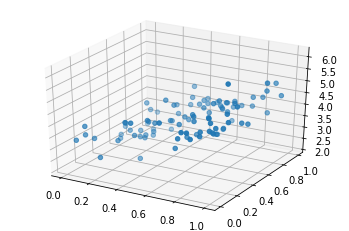

In [27]:

def rff_model_sample(Theta,Omega,B,model_X):
	sampled_X = numpy.linspace(model_X.min(axis=0),model_X.max(axis=0),100)
	Phi = apply_RFF_transform(sampled_X,Omega,B)
	sampled_Y = Phi.dot(Theta)
	return sampled_X, sampled_Y

def vis_rff_model(train_X, train_Y, Theta, Omega, B):
	sample_X, sample_Y = rff_model_sample(Theta,Omega,B, train_X)
	plot_helper(train_X, train_Y, sample_X, sample_Y)

if __name__ == '__main__':
	data_X, data_Y = load_data('2D-noisy-lin.txt')
	plot_helper(data_X, data_Y)